### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

In [2]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


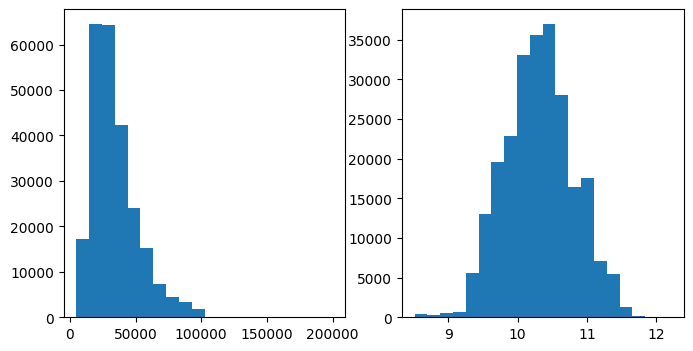

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
66899,68715028,Management Accountant,The job will be specifically to assist with th...,Oxford Oxfordshire South East,Oxford,NaN,contract,Page Personnel Finance,Accounting & Finance Jobs,0 to 15 per hour,14400,totaljobs.com,9.575053
130163,70164894,Part Time Payroll Clerk,Part Time Weekly Payroll Clerk Tuesday (all da...,"Bradford, West Yorkshire, England, West Yorkshire",Bradford,NaN,permanent,Interaction Recruitment,Accounting & Finance Jobs,5000 - 5200/annum,5100,cv-library.co.uk,8.537192
190282,71741810,Sous Chef – 1 Michelin Restaurant,Sous Chef – 1 Michelin Restaurant I am recruit...,London South East,South East London,NaN,NaN,Hush Recruitment Ltd,Hospitality & Catering Jobs,"From 26,000 to 31,000 per annum",28500,caterer.com,10.257694


In [6]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE
tokenized_data = [tokenizer.tokenize(text) for text in data['FullDescription']]
data.loc[:, 'FullDescription'] = [' '.join(tokenized_data[i]).lower() for i in range(len(tokenized_data))]

In [7]:
tokenized_data = [tokenizer.tokenize(str(text)) for text in data['Title']]
data.loc[:, 'Title'] = [' '.join(tokenized_data[i]).lower() for i in range(len(tokenized_data))]

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


In [9]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>
for title in data['Title'].values:
    for token in title.split():
        token_counts[token] += 1

for desc in data['FullDescription'].values:
    for token in desc.split():
        token_counts[token] += 1

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [13]:
token_to_id = {}
for i, token in enumerate(tokens):
    token_to_id[token] = i

In [14]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


In [16]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [19]:
device

'cuda'

In [89]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(len(tokens), 100, padding_idx=PAD_IX)
        self.conv1 = torch.nn.Conv1d(100, 200, kernel_size=5, padding=2)
        self.conv2 = torch.nn.Conv1d(100, 200, kernel_size=2, padding=1)
        
    def forward(self, idx):
        # [batch_size, text_len]
        embs = self.emb(idx)
        # [batch_size, text_len, emb_size]
        embs = embs.transpose(2, 1)
        # [batch_size, emb_size, text_len]
        conv_outs1 = self.conv1(embs)
        conv_outs2 = self.conv2(embs)
        # [batch_size, out_channels, out_len]
        max_pool1 = torch.max(conv_outs1, dim=-1).values
        max_pool2 = torch.max(conv_outs2, dim=-1).values
        # [batch_size, out_channels]
        
        return torch.cat([max_pool1, max_pool2], dim=1)

# class TextEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.emb = torch.nn.Embedding(len(tokens), 100, padding_idx=PAD_IX)
#         self.lstm = nn.LSTM(100, 64, num_layers=1, bidirectional=True, batch_first=True)
        
#     def forward(self, idx):
#         # [batch_size, text_len]
#         embs = self.emb(idx)

#         lstm_out, _ = self.lstm(embs)
#         return torch.mean(lstm_out, dim=1)

class CategoricalEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3768, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.title_enc = TextEncoder()
        self.desc_enc = TextEncoder()

        self.title_enc.emb = self.desc_enc.emb

        self.cat_enc = CategoricalEncoder(output_dim=100)

        self.regressor = nn.Sequential(
            nn.Linear(200+200+200+200+100, hid_size),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_batch = batch['Title']
        desc_batch = batch['FullDescription']
        cat_batch = batch['Categorical']

        title_features = self.title_enc(title_batch)
        desc_features = self.desc_enc(desc_batch)
        cat_features = self.cat_enc(cat_batch)

        total_features = torch.cat([title_features, desc_features, cat_features], dim=1)
        result = self.regressor(total_features)
        return result.ravel()

In [71]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [60]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

In [61]:
from tqdm.auto import tqdm

In [92]:
BATCH_SIZE = 64

def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [63]:
# import gensim.downloader

# embeddings = gensim.downloader.load("glove-wiki-gigaword-100")
# print(gensim.downloader.info()['models'].keys())

# embs = []
# for token in tqdm(tokens):
#     if token in embeddings.index_to_key:
#         embs.append(embeddings[token])
#     else:
#         embs.append(np.random.uniform(size=(100)))
# embs = np.array(embs)

In [96]:
model = SalaryPredictor(hid_size=64).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
            
model.apply(initialize_weights)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' not in name:
            nn.init.constant_(param.data, 0)
        elif 'emb' in name:
            param.data[1] = torch.zeros([100], device=device, requires_grad=True, dtype=torch.float)
            
model.apply(init_weights)

SalaryPredictor(
  (title_enc): TextEncoder(
    (emb): Embedding(34158, 100, padding_idx=1)
    (conv1): Conv1d(100, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv2): Conv1d(100, 200, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (desc_enc): TextEncoder(
    (emb): Embedding(34158, 100, padding_idx=1)
    (conv1): Conv1d(100, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv2): Conv1d(100, 200, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (cat_enc): CategoricalEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=3768, out_features=256, bias=True)
      (1): Dropout(p=0.3, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=100, bias=True)
    )
  )
  (regressor): Sequential(
    (0): Linear(in_features=900, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

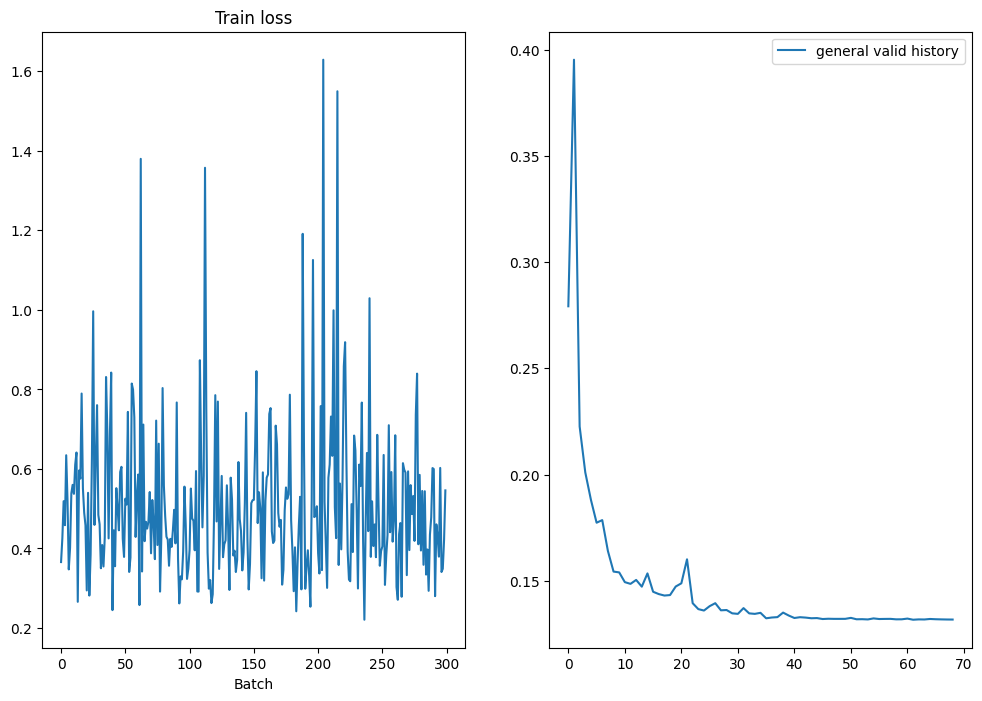

 13%|██████████▏                                                                    | 395/3059 [00:10<01:08, 39.06it/s]


KeyboardInterrupt: 

In [97]:
EPOCHS = 110
MODEL_NAME = './classifier.pt'
best_valid_loss = float('inf')

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=3,
                                                      factor=0.5,
                                                      verbose=True)

lr_sched = lr_scheduler(optimizer)

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()

    history = []
    train_loss = 0
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%100==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if val_loss_history is not None:
                ax[1].plot(val_loss_history, label='general valid history')
            plt.legend()
            
            plt.show()

    _, valid_loss = print_metrics(model, data_val, device=device)
    lr_sched.step(valid_loss)

    val_loss_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)

In [98]:
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cuda')))
print_metrics(model, data_val, device=device)

 results:
Mean square error: 0.04045
Mean absolute error: 0.13168


(0.04045100803736033, 0.13167600978086572)

In [80]:
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cuda')))
print_metrics(model, data_val, device=device)

 results:
Mean square error: 0.04201
Mean absolute error: 0.13845


(0.042005976951896166, 0.13845143328111595)

- Батч нормализация сделала только хуже
- Чрезмерное уввеличение параметров лучше не делает
- Свертки показали себя лучше всего, LSTM дает не прям ужасный результат, но и не лучше сверток
- Dropout полезен
- Adam > SGD
- Инициализация весов предобученными эмбеддингами лучше не сделала
- LRScheduler помогает

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!